# Fondamenti di Fisica Computazionale

#### Raffaele Mura 70/89/00373

# Assignment 1.0 

### Esperimento di Rutherford




In questa prima parte del progetto si è interessati a simulare numericamente l'esperimento di diffusione di Rutherford. Lo  scopo di questo è quello di verificare il modello atomico di Rutherford secondo il quale ogni atomo è formato da un nucleo pesante e di carica positiva attorno al quale "orbitano" gli elettroni, più leggeri e negativi. <br>
Per verificare tale ipotesi un fascio di particelle $\alpha$ (nuclei di $He^4$ aventi carica 2e) viene fatto incidere contro una sottile lamina metallica (ad esempio d'oro) e se ne studia la distribuzione angolare. Secondo l'ipotesi il fascio di particelle $\alpha$ verrà diffuso ad un certo angolo $\theta$ dalla presenza del campo elettrico formato dal nucleo positivo.
<br> 
Considerando il nucleo fisso (la massa del nucleo è molto maggiore rispetto a quella delle paricelle $\alpha$) e trascurando l'interazione tra particelle $\alpha$ ed elettroni (la massa degli elettroni è molto più piccola rispetto alla massa della particella $\alpha$), la distribuzione angolare del fascio è data da:

$N(\theta)={N_0 \over sin^4({\theta \over 2})}$
<br> 


Nel nostro caso verrà simulato un fascio di particelle incidente su di un nucleo d'oro.
In primo luogo siamo interessati a simulare la traiettoria di una singola particella $\alpha$, il cui moto sarà governato dalla legge di Coulomb:

$ F=kq_1q_2{\vec r_1 - \vec r_2 \over ||\vec r_1 - \vec r_2||^3  }$

La particella diffonderà sull'atomo di oro avente posizione nell'origine e sarà quindi necessario misurare l'angolo di diffusione $\theta$ dipendente dal parametro d'impatto $b$, il quale indica la distanza perpendicolare tra la traiettoria della particella $\alpha$ ed il centro diffusore. 
<br> 
Posta la particella ad una certa posizione iniziale nelle tre dimensioni, e inizializzata ad una certa velocità, tramite un procedura di integrazione numerica saremmo in grado di determinare posizioni e velocità di essa ad intervalli discreti di tempo (time-step $\tau$) . Quindi stabilito un passo temporale di integrazione, e iterato il processo per un numero finito di cicli, saremmo in grado di calcolare con un certo errore, la traiettoria della particella. <br> 

Lo strumento che si utilizzerà nel corso del progetto sarà l'algoritmo di Velocity Verlet, che permette di integrare numericamente le equazioni del moto, con un errore verificabile di $o(\tau^4) $ e con la conservazione  del'energia totale del sistema.<br> 
Sarà fondamentale nell'implementazione del progetto definire correttamente il time-step e il numero N di passi temporali (cicli), coerentemente all'applicazione implementata

Prima di definire queste grandezze sarà inizialmente utile importare tutte le librerie utili allo svoglimento e definire le costanti fondamentali utili al contesto.
Si definiscono le particelle $\alpha$ come appunto nuclei di $He^4$ aventi carica 2e.
Si definisce poi la parte costante dell'accelerazione dovuta alla forza di Coulomb $F_0$, fondamentale per l'utilizzo dell'algoritmo Velocity Verlet. <br> 

In seguito si definisce l'energia $E$ della particella $\alpha$ pari a 5 MeV valore molto simile a quello utilizzato nell'esperimento di Rutherford.

Se si calcola il rapporto tra F0 ed E si ottiene una distanza, questa è dell'ordine dei $10^{-14}$metri ed è molto vicina alla distanza minima a cui una particella che urta frontalmente contro il cetro diffusore arriverebbe. 
Se una particella incide frontalmente ($b=0$), la distanza a minima a cui arriva la particella vicino al diffusore è $d$. 
Essendo un'unita di lunghezza tipica del problema è utile integrare in modo tale da compiere una distanza d alla volta. 
Se si ricava la velocità dall'energia, il rapporto ${d \over v}$ sarà il tempo $\tau$ per cui andremo a integrare.
Si calcola quindi la varibile $vel$ e si definisce $\tau$.

NB. Tutte le grandezze vettoriali presenti nel codice sono definite attraverso una classse di vettori in 3 dimensioni sotto riportata, in cui sono implementate tutte le operazioni su vettori utili nel caso del progetto. Nell'implementazione del codice si rispetterà la notazione CamelCase



In [79]:
import numpy as np

class CVector3D:

    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def mod(self):
        return np.sqrt(self.x ** 2 + self.y ** 2 + self.z**2)

    def unitary(self):
        modulo = self.mod()
        return CVector3D(self.x / modulo, self.y / modulo, self.z/modulo)

    def __add__(self,other):
        return CVector3D(self.x + other.x, self.y + other.y, self.z+other.z)

    def __sub__(self,other):
        return CVector3D(self.x - other.x, self.y - other.y,self.z-other.z)

    def __mul__(self,other):
        if type(other) == CVector3D:
            return self.x * other.x + self.y * other.y + self.z*other.z
        return CVector3D(self.x * other, self.y * other, self.z*other)

    def __rmul__(self,other):
        return self*other

    def __truediv__(self, other):
        return self*(1/other)

    def __str__(self):
        return "("+str(self.x)+","+str(self.y)+","+str(self.z)+")"

    def get_angle(self,other):
        return np.arccos(self*other/(self.mod()*other.mod()))


In [80]:
import numpy as np
import scipy.constants as spc
import CVector3D as vec
import scipy.optimize as spo
import matplotlib.pyplot as plt

Z1, Z2 = 2, 79 #numero atomico rispettivamnete dell'elio e dell'oro
alpha_mass = 2 * spc.proton_mass + 2 * spc.neutron_mass #kg
F0 = Z1 * Z2 * spc.e ** 2 / (4 * np.pi * spc.epsilon_0 * alpha_mass) #N*m^2 /kg
E = 5 * 1e6 * spc.electron_volt #N*m
d0 = F0 / E * alpha_mass #m
vel = np.sqrt(2 * E / alpha_mass)
tau = d0 / vel

Definiamo la funzione (FCoulomb) forza di Coulomb che dovrà restituire ${F_0 \vec r}\over {\vec r^{3}}$, in cui $\vec{r}$ indica il vettore posizione della particella $\alpha$ rispetto all'origine in cui è posto il nucleo d'oro.<br> 
La funzione ci restituirà un vettore forza.

In [81]:
def FCoulomb(x, y, z):                               
    r = vec.CVector3D(x, y, z)                    
    return F0 * r / r.mod()**3

Si implementerà ora il metodo di integrazione per le equazioni differenziali, secondo l'algoritmo di VVerlet.
Il metodo Step prenderà la posizione e la velocità della particella e integrerà l'equazione differenziale per un tempo $\tau$. 
<br>
Il calcolo numerico avverrà secondo le espressioni:
- $\vec x_{n+1}=\vec x_n +\vec v_n \tau +\vec F_n{\tau^2 \over 2}$
-$\vec v_{n+1} = \vec v_n+{\tau \over 2}(\vec F_n + \vec F_{n+1})$ 
<br>
<br>

Che equivalgono rispettivamente ai nuovi vettori posizione e velocità calcolati allo step i-esimo in funzione del time-step, e dei vettori posizione, velocità e forza calcolati allo step precedente. 
<br>
Ora volendo compiere N steps di integrazione creiamo una funziona Run che iteri N vole Step.

In [82]:
def Step(r, v, tau):                      
    new_r = r + v * tau + FCoulomb(r.x, r.y, r.z) * tau**2 / 2
    new_v = v + (FCoulomb(r.x, r.y, r.z) + FCoulomb(new_r.x, new_r.y, new_r.z)) * tau / 2
    return new_r, new_v

def Run(r0, v0, tau, N):
    
    r, v = [r0], [v0]
    for i in range(N - 1):
        new_r, new_v = Step(r[i], v[i], tau)
        r.append(new_r)
        v.append(new_v)
    
    return r, v

Subito sotto è riportata la funzione main il cui fine è di governare l'algoritmo di integrazione, dati determinati parametri iniziali, quali le condizioni iniziali, il parametro d'impatto $b$ e il numero di particelle. La funzione itererà la procedura un numero di volte pari al numero di particelle componenti il fascio. <br>
In primo luogo siamo interessati a misurare l'angolo  $\theta$  a cui è diffusa la particella $\alpha$ al variare del parametro d'impatto $b$. <br>
Per cui il main verrà chiamato con questo intento. <br>
La velocità iniziale sarà diretta parallelamente all'asse $x$ e con modulo $vel$.<br>
La posizione iniziale sarà così posta "*(-50, i , 0)*d0*"  facendo quindi iterare il parametro d'impatto solo  nella sua componente y (da 0 a 100). La scelta di far variare il parametro d'impatto solamente lungo i valori positivi dell'asse y è dettata dalla simmettria sferica del potenziale coulombiano. <br>
Per quanto rigaurda il numero di passi da compiere per porci sufficentemente lontani da compiere una corretta misurazione dell'angolo $\theta$, procederemo con un numero di steps pari a due volte la distanza iniziale $\vec r_0$ (la sua componente $x$), diviso il passo temporale $d0$.  



In [83]:
NPart=1
BRand=False

def main(NPart,BRand):
    
    np.random.seed()
    theta = []
    N_part = NPart
    
    rpos1=[]
    rpos2=[]
    rpos3=[]
    if BRand:
        
        for i in range(N_part):
                      
            r0 = vec.CVector3D(-50, (2 * np.random.rand() - 1)*15 , (2 * np.random.rand() - 1)*15 )  * d0
            v0 = vec.CVector3D(1, 0, 0) * np.sqrt(2 * E / (2 * spc.proton_mass + 2 * spc.neutron_mass))
            tau = d0 / v0.mod()
            
            N = 3 * int(r0.mod() / d0)

            r, v = Run(r0, v0, tau, N)
            TmpVel=v[-1]
            
            if i == 5:
                rpos1=r
            if i == 10:
                rpos2=r
            if i == 20:
                rpos3=r              
            
            
            
            theta.append(TmpVel.get_angle(v0))
        return theta, r, rpos1,rpos2,rpos3
    else:
        for i in range(100):
            
            r0 = vec.CVector3D(- 50, i, 0) * d0
            v0 = vec.CVector3D(1, 0, 0) * np.sqrt(2 * E / (2 * spc.proton_mass + 2 * spc.neutron_mass))
            tau = d0 / v0.mod()
            N = 2 * int(r0.mod() / d0)

            r, v = Run(r0, v0, tau, N)
            TmpVel=v[-1]
            
            if i == 5:
                rpos1=r
            if i == 10:
                rpos2=r
            if i == 20:
                rpos3=r
            
            theta.append(TmpVel.get_angle(v0))
        return theta,r, rpos1, rpos2, rpos3 

theta,r,rpos1,rpos2,rpos3=main(NPart, BRand)

Infine plottiamo il risultato

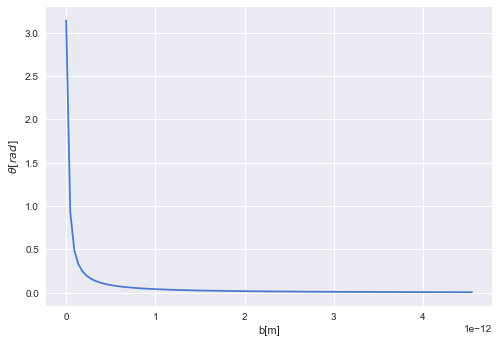

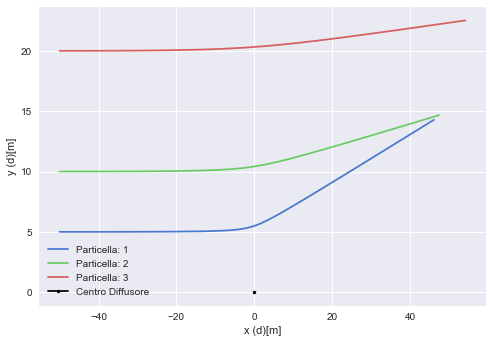

In [84]:
fig0,ax0 = plt.subplots()
x=np.linspace(0,100*d0,100)
line,=ax0.plot(x,theta)
ax0.set_xlabel("b[m]")
ax0.set_ylabel("$\\theta[rad]$")
plt.show()


fig1, ax1 = plt.subplots()
ax1.plot([pos.x/d0 for pos in rpos1], [pos.y/d0 for pos in rpos1], label='Particella: 1')
ax1.plot([pos.x/d0 for pos in rpos2], [pos.y/d0 for pos in rpos2], label='Particella: 2')
ax1.plot([pos.x/d0 for pos in rpos3], [pos.y/d0 for pos in rpos3], label='Particella: 3')
ax1.plot(0, 0, marker=".", color="k",label='Centro Diffusore')
ax1.set_xlabel("x (d)[m]")
ax1.set_ylabel("y (d)[m]")
ax1.legend()

Il primo grafico mostra come per parametro di'impatto nullo, la particella abbia un angolo di deflessione di $\pi$ viene quindi respinta, e poi come l'angolo diminuisca sensibilmente col'aumentare di $b$, comer atteso dalla teoria di Rutherford.
Il secondo grafico mostra la traiettoria di tre particelle con diversi $b$.<br>
Ora si ripeterà la simulazione con un numero N di particelle, generate con un parametro d'impatto casuale, e si verificherà che la distribuzione angolare sia data da: <br> $N(\theta)={N_0 \over sin^4({\theta \over 2})}$


In [85]:
NPart=1000000
BRand=True
theta,r,rpos1,rpos2,rpos3=main(NPart, BRand)

Normalizzazione: 60.6573634657446
Esponente: 4.061286893730852
Con un errore sull'esponente: 0.0006202991273631258


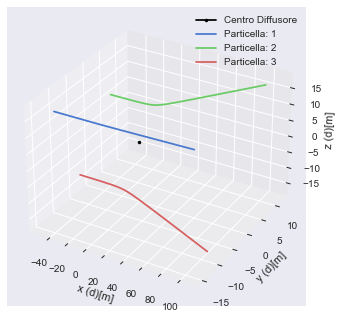

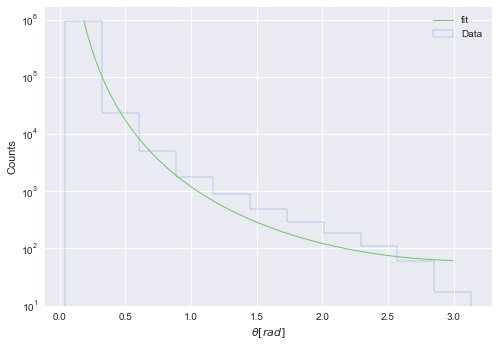

In [86]:
from mpl_toolkits.mplot3d import Axes3D

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(0, 0, 0, marker=".", color="k", label='Centro Diffusore' )
x=[pos.x/d0 for pos in rpos1]
y=[pos.y/d0 for pos in rpos1]
z=[pos.z/d0 for pos in rpos1]
ax1.plot(x, y, z, label='Particella: 1')

ax1.set_xlabel("x (d)[m]")
ax1.set_ylabel("y (d)[m]")
ax1.set_zlabel("z (d)[m]")
x=[pos.x/d0 for pos in rpos2]
y=[pos.y/d0 for pos in rpos2]
z=[pos.z/d0 for pos in rpos2]
ax1.plot(x, y, z, label='Particella: 2')

x=[pos.x/d0 for pos in rpos3]
y=[pos.y/d0 for pos in rpos3]
z=[pos.z/d0 for pos in rpos3]
ax1.plot(x, y, z, label='Particella: 3')
ax1.legend()


def fit(theta, N, alpha):
    return N  / ( np.sin(theta / 2)**alpha)

fig, ax = plt.subplots()
ax.hist(theta, histtype = "step", bins = 11, label = "Data")
ax.set_yscale("log")

counts, bins = np.histogram(theta, bins = 11)
bins = bins[1:] - (bins[1] - bins[0]) / 2
p, cov = spo.curve_fit(fit, bins, counts, p0 = [1, 4])
print("Normalizzazione:",p[0])
print("Esponente:",p[1] )
print("Con un errore sull'esponente:",cov[1,1])
x = np.linspace(bins[0], bins[-1], 1000)
y = fit(x, p[0], p[1])

ax.plot(x, y, label = "fit", linewidth = 1)
ax.set_ylabel("Counts")
ax.set_xlabel("$\\theta[rad]$")
ax.legend()

plt.show()


Il primo grafico rappresenta la traiterroria di una particella $\alpha$, ad un parametro d'impatto $b$ casuale. <br>
L'istogramma rappresenta i conteggi effettuati per intervallo di  $\theta$ . Viene poi riportato subito sopra il fit della distirbuzione angolare che vede come parametri fittati quelli calcolati dalla funzione curve_fit, che dopo aver ricevuto la funzione $\lambda$ (funzione 'modello'), calcola la normalizzazione $N_0$ e l'esponente del seno nella relazione della distirbuzione del numero $\Delta N(\theta)$ di particelle. 
<br>

Anche in questo caso i risultati ottenuti sono in accordo con quelli attesi.


# Assignment 1.1 

### Dinamica Molecolare






In un'applicazione di Dinamica molecolare classica si è interessati all'evoluzione di un sitema a livello atomico e molecolare. Ciò avviene tramite la risoluzione numerica delle equazioni del moto attraverso tecniche computazionali e algoritmi. <br>
Nel caso del sistema atomico specifico, però, differentemente dal progetto precedente, non siamo a conoscenza del potenziale di interazione e quindi della forma funzionale della forza che governa il nostro sistema.
Dal punto di vista più pratico, utilizzando un metodo di integrazione numerica delle equazioni del moto, non siamo in grado di aggiornare le forze nel nostro algoritmo.<br>

In linea di principio, per risolvere un problema atomistisco in ambito di meccanica quantistica, dovremmo risolvere l'equazione di Schrödinger.
Ciò non è computazionalmente sostenibile in questo ambito,per cui la soluzione sarà trovare dei potenziali specifici ricavati empiricamente che descrivano l'interazione tra gli atomi in uno specifico sistema.<br>

il potenziale modello va scelto coerentemente col sistema che si vuole studiare. Esso quindi andrà a utilizzare funzioni matematiche per determinare l'energia potenziale di una data configurazione di atomi.<br> 

La forma funzionale che ci permette di ricavare l'energia potenziale del sistema, partendo dalla posizione degli atomi, per poi calcolarne la derivata e quindi, tramite le forze, far evolvere il nostro sistema è il potenziale di *Lennard - Jones*, che consiste in una somma tra una parte attrattiva e una repulsiva che dipendono dalla distanza tra i due atomi. 

$E(r)=4\epsilon \big({\sigma \over r} \big)^{12}-4\epsilon \big({\sigma \over r} \big)^6$

Calcoleremo quindi le forze come il gradiente del potenziale stesso.<br>

Nel particolare si studierà un sistema bidimensionale formato da particelle sono di Arogn, un gas nobile, difficilmente ionizzabile, che caratterizzarà i parametri $\sigma$ ed $\epsilon$ del potenziale. Dove $\sigma$ definisce il punto in cui la forza attrativa è nulla, invece $\epsilon$ definisce qual è l'energia di legame fra le particelle.<br>

Per ciò che rigaurda l'integrazione dell'equazioni del moto si utilizzerà l'algoritmo VVerlet, con time step e tempo di osservazione del sistema scelti in funzione del contesto. <br>

In ambito di simulazioni di Dinamica Molecolare il valore per il passo temporale è generalmente dell'ordine di $10^{-15}$ secondi. In questo caso sarà commisurato con le capacità del calcolatore in uso. 
<br>
NB. Per la simulazione in due dimensioni verrà utilizzata la classe CVector2D che implemente le operazioni tra vettori di due dimensioni utili al progetto. Nella classe non si è implementata una parte di Raise di eccezioni per tutti i metodi: queste sono state implementate principalmente per i metodi in cui potevano verificarsi degli errori nello sviluppare il codice. Si riporta quindi l'implementazione della classe.

In [87]:
import numpy as np

class CVector2D:

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def mod(self):
        return np.sqrt(self.x ** 2 + self.y ** 2)
    
    def __mod__(self,other):
        if type(other) == CVector2D:
            raise ValueError("Non è implementato l'operatore % con un altro vettore")
        return CVector2D(self.x % other, self.y % other)
     
   
    def __radd__(self, value):
        return self.__add__(value) #commutative
   
    def __pos__(self):
        return self

    def unitary(self):
        modulo = self.mod()
        return CVector2D(self.x, self.y)/modulo

    def __add__(self,other):
         
        if type(other)==CVector2D:
            CVector2D(self.x + other.x, self.y + other.y)
        raise TypeError("Other non è un vettore in 2d")
   
    def __sub__(self,other):
        return CVector2D(self.x - other.x, self.y - other.y)

    def __mul__(self,other):
        if type(other) == CVector2D:
            return self.x * other.x + self.y * other.y
        return CVector2D(self.x * other, self.y * other)

    def __rmul__(self,other):
        return self*other
    
    def __neg__(self):
        return CVector2D(-self.x, -self.y)

    def __truediv__(self, other):
        return self*(1/other)

    def __str__(self):
        return "("+str(self.x)+","+str(self.y)+")"


In aggiunta alla classe di vettori, è stata creata una classe che gestisce l'entità particella.<br> Le funzioni di aggiornamento della posizione e della velocità tipiche di VVerlet, sono implementati come metodi di istanza della classe.<br>
Oltre alla parte di integrazione delle equazioni del moto è presente un metodo di istanza che verificano la vicinanza di altre particelle rispetto alla particella i-esima in esame. <br>
Il metodo Close restituisce una lista con le particelle la cui posizione è minore di un certo raggio di interazione pari a 5 volte $\sigma$. Il metodo Interact invece implementa il concetto di cutoff, restituendo un vettore, che rappresenterà la forza, pari alla derivata del potenziale, in caso le particelle siano considerate vicine, altrimenti pari a 0. 

In [88]:
import CVector2D as v
import numpy as np

class CParticle:
    def __init__(self, pos, vel, L, T=300):
        self.pos = pos
        self.vel = vel
        self.L = L
        self.mass = 39.984
        self.T = T

    def UpdatePos(self, force, dt):
        
        
        
        new_pos = self.pos + self.vel * dt + 0.5 * force * dt * dt
              
        
        
        
        return new_pos 

    def UpdateVel(self, force, new_force, dt):

        
        
        
        new_vel=self.vel + 0.5 * (force + new_force) * dt 
        
      
        
        return new_vel

   
    def interact(self, other, sigma, epsilon):
        r=other.pos-self.pos
        d = r.mod()
        if d<=3*sigma:
            return 4 * epsilon * (12*sigma**12 / d**13 - 6 * sigma**6/d**7)*r.unitary()
        return v.CVector2D(0,0)


Il main del codice governa la procedura riguardante sia il calcolo delle interazioni tra particelle sia dello sviluppo degli steps per l'evoluzione del sistema. <br>
Il main crea delle matrici posizioni e velocità, che hanno un numero di colonne pari al numero di particelle e un numero di righe pari agli steps scelti.Le matrici dopo essere state inizializzate con velocità e posizioni all'stante 0, all'evolvere del sistema conterranno posizioni e velocità di ogni particella in ogni step. <br>
Ugualmente la funzione UpdateForces cooperando con il metodo delle particelle Close() verificherà le forze interagenti tra le diverse particelle. <br><br>
Le forze ricavate dovranno essere direzionate,infatti è noto come la forza di interazione sia sempre diretta lungo la congiungente i due atomi. Si definisce quindi un versore che congiunge i due atomi. Il verso è dato dal calcolo della derivata dell'energia potenziale rispetto alle direzioni.
Con questa procedura sarà possibile capire come è orientata la forza (implementata nel metodo interact).<br>
Questa operazione andrebbe teoricamente fatta con tutti gli atomi che compongono il sistema.<br> Ciò però avrebbe un costo computazionale dell'ordine di  $n^2$. Il problema può essere in parte aggirato sfruttando la terza legge di Newton, tramite la quale è noto come la forza dell'atomo i-esimo agente sull'atomo j-esimo sia opposta a quella dell'atomo j-esimo agente sull'i-esimo. Questo viene implementato nel penultimo ciclo di iterazione UpdateForces,abbassando così il costo computazionale a  $n(n-1)$.  abbassando così il costo computazionale a  $n(n-1)$


In [89]:
def Step(particles, dt, sigma, epsilon, forces,N_part):
    
    newpos=[]
    newvel=[]
    
    for i in range(N_part):
        new_pos=particles[i].UpdatePos(forces[i], dt)
        particles[i].pos=new_pos
        newpos.append(new_pos)
    new_forces = UpdateForces(particles, sigma, epsilon,N_part)
    
    
    for i in range(N_part):
        new_vel = particles[i].UpdateVel(forces[i], new_forces[i], dt)
        particles[i].vel=new_vel
        newvel.append(new_vel)
    
    return np.array(newpos), np.array(newvel), new_forces

def UpdateForces(particles, sigma, epsilon,N_part):
    
    forces = np.full([N_part,N_part], v.CVector2D(0,0))
    
    for i in range(N_part-1):
        for j in range(i+1, N_part):
            
            force = particles[i].interact(particles[j], sigma, epsilon)
                
            forces[i][j] = force
                
            forces[j][i] = -force
    

               
    return np.sum(forces, axis=0)


def main(particles, dt, sigma, epsilon, N_steps,N_part):
    
    positions =  np.full([N_steps, N_part], v.CVector2D(0,0))
    velocities =  np.full([N_steps, N_part], v.CVector2D(0,0))
   
    positions[0, :] = np.array([particle.pos for particle in particles])

    velocities[0, :] = np.array([particle.vel for particle in particles])
    
    forces = UpdateForces(particles, sigma, epsilon,N_part)
    for i in range(N_steps):   
        
        new_pos, new_vel, new_forces = Step(particles, dt, sigma, epsilon, forces,N_part)
        forces=new_forces
        
        positions[i, :] = new_pos
        velocities[i, :] = new_vel
        
    return positions, velocities

Dopo aver definito le classi e funzioni alla base del codice, e dopo aver importato le librerie necessarie, si definisco le variabili utili alla simulazione. Nel particolare si definisco i parametri $\sigma$ ed $\epsilon$ che caratterizzano il potenziale per la particella dell'Argon.<br>
Si stabilisce inoltre il numero di particelle e la grandezza del box misurata in funzione del numero di particelle.
Infine si inizializza una lista di particelle, quali oggetti della classe CParticles.<br>
La velocità iniziale delle singole particelle è scleta di direzione e verso randomica e con modulo dato da: 

$E_K=\sum_{i=1}^N{m_i|\vec v_i|^2 \over 2}= {3 \over 2} Nk_BT$

<br>
Il fulcro del progetto sarà proprio verificare come dopo N steps di integrazione l'evolzuione del sistema seguirà una distirbuzione di velocità tipica di Maxwell-Boltzmann:

$P(v)=C{v^2 \over K_bT}e^{-mv^2 \over 2 k_BT} $


In [90]:

import numpy as np
import CParticle as p
import CVector2D as v
import matplotlib.pyplot as plt
import scipy.constants as spc
import scipy.optimize as spo

argon_mass=39.984
sigma,epsilon=3.46,0.0103
N_part=64
L_box=100
T=300
N_steps=10000


def random_vel(T, argon_mass):
    P=np.random.rand(2)-0.5
    R=v.CVector2D(P[0], P[1])
    R=R.unitary()
    R=R*np.sqrt(spc.Boltzmann *T/(argon_mass*spc.electron_volt))
    
    return R
    


particles=[]
for i in range(4):
    for j in range(16):
        particle=p.CParticle(v.CVector2D(1.075*sigma*i+10, 1.075*sigma*j+5),random_vel(T,argon_mass),L_box,T)
        particles.append(particle)
        
    

positions, velocities=main(particles,0.01,sigma,epsilon,N_steps,N_part)

Il codice che segue implementa le funzioni atte al raccoglimento dei dati e al plottaggio di essi.

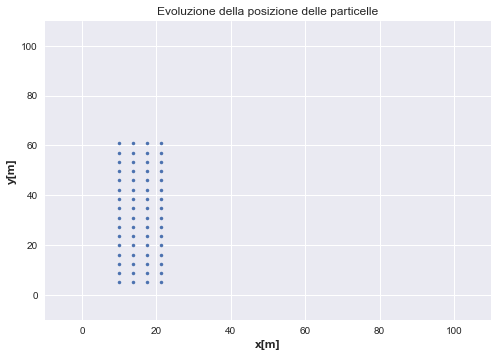

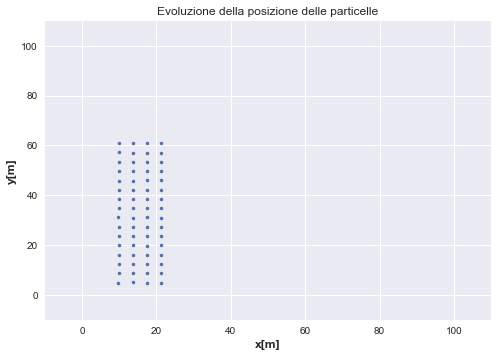

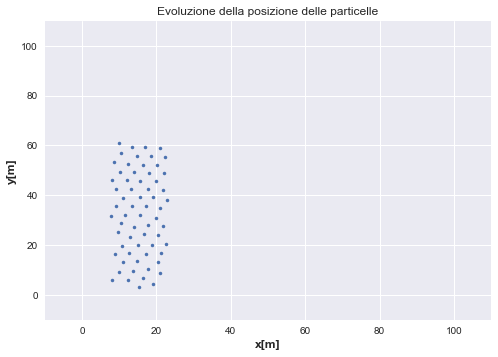

p: [3.87478429e-20 1.63624382e-21]


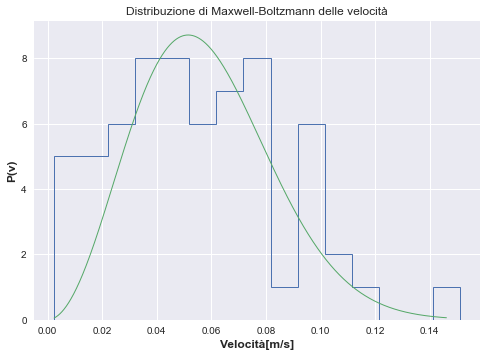

In [107]:
def get_xy(positions, k):
    
    pos=positions[k, :]
    
    x=[]
    y=[]
    
    for i in pos:
        
        x.append(i.x)
        y.append(i.y)
    
    
    return x,y

def get_mod(velocities):

    
    vel_mod=[]

    for i in velocities[-1, :]:
        tempvel=i.mod()
        vel_mod.append(tempvel)

    
    return vel_mod


def fit(v,A,alpha):
    return A*v**2*np.exp(-alpha*v**2)



x=[0,500, 9999]
for i in x:
    plt.style.use('seaborn')
    fig, ax = plt.subplots()
    xpos1,ypos1=get_xy(positions, i)
    
    ax.set_xlabel("x[m]", fontsize='large',fontweight='bold')
    ax.set_ylabel("y[m]", fontsize='large',fontweight='bold')
    plt.title('Evoluzione della posizione delle particelle')
    line,=ax.plot(xpos1,ypos1, linewidth=0, marker="." )
    ax.set_xlim(-10, L_box+10)
    ax.set_ylim(-10, L_box+10)
plt.show()



fig1,ax1=plt.subplots()
plt.style.use('seaborn-muted')
mod=get_mod(velocities[:])
ax1.hist(mod, histtype="step", bins=15, linewidth=1)
ax1.set_xlabel("Velocità[m/s]", fontsize='large',fontweight='bold')
ax1.set_ylabel("P(v)", fontsize='large',fontweight='bold')
plt.title('Distribuzione di Maxwell-Boltzmann delle velocità')
counts, bins = np.histogram(mod, bins=15)
b_width=(bins[1]-bins[0])/2
bins=bins[1:]-b_width
p,cov=spo.curve_fit(fit,bins,counts)
x=np.linspace(bins[0]-b_width,bins[-1],1000)
ax1.plot(x,fit(x, p[0], p[1]), linewidth=1)

print("p:",p /(argon_mass/ (spc.Boltzmann*4*np.pi)))

plt.show()


Il primo insieme di grafici illustra le N particelle nel box in istanti diversi, evidenziando quindi l'evoluzione del sistema. <br>
Il secondo grafico illustra la distribuzione di velocità delle particelle nel box. Come atteso queste seguono la distribuzione di Maxwell-Boltzmann.
<br><br>

Ora si studierà il processo di diffusione degli atomi di argon, calcolando lo spostamento quadratico medio in funzione del tempo:
$\Delta R(t)^2 = {1 \over N}\sum_{i=1}^N|\vec r_i(t)-\vec r_i(0)|^2 $
Implementandone il relativo codice. <br>

Lo scopo è quello di dimostrare il moto browniano delle particelle simulate verificando l'equazione di Einstein:
<br>
$\Delta R(t)^2 \approx D t$
<br>in cui D è il coefficiente di autodiffusione del materiale di studio.


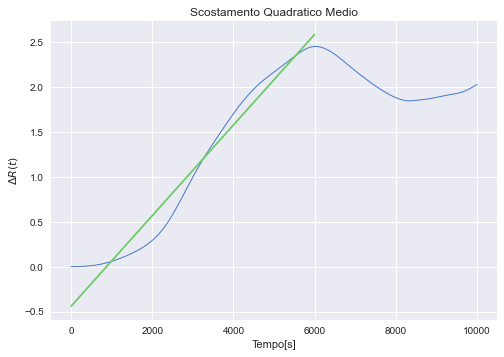

Coefficiente autodiffusione Argon[m^2/s]: 0.00012613558900138124


In [106]:
def scostamentoquadraticomedio(positions):
    
    scost=[]
    for i in range (N_steps):
        somma=0
        for j in range (N_part):
            temp_part=(positions[i,j]-positions[0,j]).mod()
            somma += (temp_part**2)
            
        scost.append(somma/N_part)   
    return scost
scost=scostamentoquadraticomedio(positions)

def linear_fit(x, A, B):
    return A * x + B

x=np.linspace(0,N_steps,N_steps)

p, cov = np.polyfit(x[0:6000], scost[0:6000], 1, cov = True)

fig2, ax2 = plt.subplots()
plt.style.use('seaborn-muted')
ax2.plot(x[0:10000],scost[0:10000], linewidth=1)
ax2.plot(x[:6000], linear_fit(x[:6000], p[0], p[1]))
plt.title('Scostamento Quadratico Medio')
#ax2.set_yscale("log")
ax2.set_xlabel("Tempo[s]")
ax2.set_ylabel("$\\Delta R(t)$")

plt.show()


print("Coefficiente autodiffusione Argon[m^2/s]:",p[0]/4)




Il grafico riporta lo scostamento quadratico medio in funzione del tempo.
Come atteso dalla formula di Einstein la relazione tra il tempo di simulazione e lo scostamento quadratico medio è di tipo lineare. 
Tramite il coefficiente angolare della retta che fitta $\Delta R(t)^2$ nella sua parte lineare iniziale, viene calcolato D stampato a schermo subito sotto. 
Il coefficiente di autodiffusione ottenuto si discosta dal risultato aspettato (circa 0.423 +- 0.003 cm^2 / s), ciò a causa delle molteplici semplificazioni del caso fatte. 
